In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import os
import seaborn as sns
import itertools
import csv
from helpers import *
from helper_funcs import *
from plots import *
from implementations import *
from data_preprocessing import *

In [2]:
current_directory = os.getcwd()

data_path = os.path.join(current_directory, 'dataset')
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)

In [3]:
print('The train and test sets include N_train={} and N_test={} data samples and have D={} features.'.format(x_train.shape[0], x_test.shape[0], x_train.shape[1]))

The train and test sets include N_train=328135 and N_test=109379 data samples and have D=321 features.


In [5]:
#Saving the generated arrays in .npy files in order to have faster access to them
np.save('../data/y_train.npy', y_train)
np.save('../data/x_train.npy', x_train)
np.save('../data/x_test.npy', x_test)
np.save('../data/train_ids.npy', train_ids)
np.save('../data/test_ids.npy', test_ids)

In [6]:
#Loading the arrays from the .npy files
x_train = np.load("../data/x_train.npy")
x_test = np.load("../data/x_test.npy")
y_train = np.load("../data/y_train.npy")
train_ids = np.load("../data/train_ids.npy")
test_ids = np.load("../data/test_ids.npy")

In [7]:
# Open the file and read only the header
file_path = os.path.join(data_path, 'x_train.csv')
with open(file_path, mode='r', newline='') as file:
    csv_reader = csv.reader(file)
    feature_names = np.array(next(csv_reader))  # Get the first row (header)
    feature_names = feature_names[-(len(feature_names)-1):]

In [8]:
## Determine the percentage of examples for which have data per feature 
N_per_feature = x_train.shape[0] - np.sum(np.isnan(x_train), axis = 0)
perc_N_per_feature = N_per_feature / x_train.shape[0]

perc_threshold = [0.7, 0.8, 0.90]
for perc in perc_threshold:
    print('Percentage of features for which examples have at least {} % of data (non-missing) = {} %'.format(100*perc, 
                                                                                                 100 * np.round(np.sum(perc_N_per_feature >= perc) / len(perc_N_per_feature),4)))

Percentage of features for which examples have at least 70.0 % of data (non-missing) = 44.86 %
Percentage of features for which examples have at least 80.0 % of data (non-missing) = 44.55 %
Percentage of features for which examples have at least 90.0 % of data (non-missing) = 43.3 %


In [9]:
## Explore the features for which 99 % of examples have (non missing) data
features_to_keep_logical = perc_N_per_feature > 0.90
feature_names[features_to_keep_logical]

array(['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE',
       'SEQNO', '_PSU', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'HLTHPLN1',
       'PERSDOC2', 'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'BLOODCHO',
       'CVDSTRK3', 'ASTHMA3', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1',
       'HAVARTH3', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'SEX', 'MARITAL',
       'EDUCA', 'RENTHOM1', 'VETERAN3', 'EMPLOY1', 'CHILDREN', 'INCOME2',
       'INTERNET', 'WEIGHT2', 'HEIGHT3', 'QLACTLM2', 'USEEQUIP', 'BLIND',
       'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100',
       'USENOW3', 'ALCDAY5', 'FRUITJU1', 'FRUIT1', 'FVBEANS', 'FVGREEN',
       'FVORANG', 'VEGETAB1', 'EXERANY2', 'STRENGTH', 'SEATBELT',
       'FLUSHOT6', 'PNEUVAC3', 'HIVTST6', 'QSTVER', 'QSTLANG', '_STSTR',
       '_STRWT', '_RAWRAKE', '_WT2RAKE', '_DUALUSE', '_LLCPWT', '_RFHLTH',
       '_HCVU651', '_RFHYPE5', '_CHOLCHK', '_LTASTH1', '_CASTHM1',
       '_ASTHMS1', '_DRDXAR1', '_PRACE1', '_MRACE1', '_HISPANC', '_RACE',
       '_

In [10]:
x_train = x_train[:,features_to_keep_logical]
x_test = x_test[:,features_to_keep_logical]
feature_names = feature_names[features_to_keep_logical]

## Clean and preprocess data
1. Select features to keep
2. Fill missing values with mode (categorical) and median (continuous)  
3. Encode (categorical) and standardize (continuous) data

In [12]:
# Select features to keep 
'''
# features_to_keep = [
'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'HLTHPLN1',
'PERSDOC2', 'MEDCOST', 'CHECKUP1',
'CVDSTRK3', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1',
'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 
'SEX', 'MARITAL', 'RENTHOM1', 'VETERAN3', 'EMPLOY1', 'INTERNET', 
'QLACTLM2', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 
'SMOKE100', 
'EXERANY2',
'FLUSHOT6', 'PNEUVAC3', 'HIVTST6', 
'_RFHYPE5', '_CHOLCHK', '_LTASTH1', '_DRDXAR1', 
'_MRACE1', '_HISPANC', '_RACEGR3', 
'_AGE80',
'HTM4', 
'WTKG3', '_BMI5CAT','_RFBMI5', 
'_CHLDCNT', '_EDUCAG', '_INCOMG', 
'_SMOKER3', 
'DROCDY3_', '_RFBING5','_RFDRHV5', 
'FTJUDA1_', 'FRUTDA1_', 'BEANDAY_', 'GRENDAY_','ORNGDAY_', 'VEGEDA1_','_FRUTSUM', '_FRTLT1', '_VEGLT1', 
'_TOTINDA', 'MAXVO2_', 'FC60_', 
'STRFREQ_', '_PACAT1', '_PAINDX1', '_PASTRNG', '_PAREC1', '_PASTAE1', 
'_LMTACT1','_LMTWRK1', '_LMTSCL1', 
'_RFSEAT2', '_RFSEAT3', 
'_AIDTST3']
'''

features_to_keep = []

features_to_keep = ['_RFHYPE5', '_CHOLCHK', '_SMOKER3', 'CVDSTRK3', '_TOTINDA', '_FRTLT1', '_VEGLT1', '_RFDRHV5', 'HLTHPLN1', 'MENTHLTH', 'SEX', '_AGEG5YR', 'EDUCA']

In [13]:
# Clean and preprocess train and test data sets
x_train, feature_names_clean, continuous_features_idx, categorical_features_idx, binary_features_idx = clean_data(x_train, feature_names, features_to_keep)
x_test, _, _, _, _ = clean_data(x_test, feature_names, features_to_keep)
feature_names = feature_names_clean

In [14]:
categorical_features_idx = np.concatenate([categorical_features_idx, binary_features_idx]).ravel()
categorical_features = feature_names[categorical_features_idx]
continuous_features = feature_names[continuous_features_idx]

In [15]:
# Preprocess train and test data sets
x_train_cat_encoded, feature_cat_map, feature_cat_encoded_map, x_train_cont_stand, feature_cont_map, x_train_cont_mean, x_train_cont_std = preprocess_data(x_train, feature_names, categorical_features_idx, continuous_features_idx)
x_test_cat_encoded, _, _, x_test_cont_stand, _, x_test_cont_mean, x_test_cont_std = preprocess_data(x_test, feature_names, categorical_features_idx, continuous_features_idx)

In [16]:
# Select features 
# selected_cat_features_idx, selected_cont_features_idx = feature_selection(x_train_cat_encoded, x_train_cont_stand)
selected_cat_features_idx = np.arange(x_train_cat_encoded.shape[1])
selected_cont_features_idx = np.arange(x_train_cont_stand.shape[1])

In [17]:
x_train_cat_encoded = x_train_cat_encoded[:,selected_cat_features_idx]
x_test_cat_encoded = x_test_cat_encoded[:,selected_cat_features_idx]
feature_cat_map =  feature_cat_map[selected_cat_features_idx]
feature_cat_encoded_map = feature_cat_encoded_map[selected_cat_features_idx]

x_train_cont_stand = x_train_cont_stand[:,selected_cont_features_idx]
x_test_cont_stand = x_test_cont_stand[:,selected_cont_features_idx]
feature_cont_map = feature_cont_map[selected_cont_features_idx]

In [18]:
if (np.size(x_train_cat_encoded) > 0) & (np.size(x_train_cont_stand) > 0):
    x_train_processed = np.hstack([x_train_cat_encoded, x_train_cont_stand])
    x_test_processed = np.hstack([x_test_cat_encoded, x_test_cont_stand])

    features_mapping = np.hstack([feature_cat_map, feature_cont_map])
    features_encoded_mapping = np.hstack([feature_cat_encoded_map, feature_cont_map])
elif (np.size(x_train_cat_encoded) > 0):
    x_train_processed = np.hstack([x_train_cat_encoded])
    x_test_processed = np.hstack([x_test_cat_encoded])
    features_mapping = feature_cat_map
    features_encoded_mapping = feature_cat_encoded_map
elif (np.size(x_train_cont_stand) > 0):
    x_train_processed = np.hstack([x_train_cont_stand])
    x_test_processed = np.hstack([x_test_cont_stand])
    features_mapping = feature_cont_map

y_train_processed = np.where(y_train == 1, 1,0).reshape(-1,1)

In [19]:
print('The continuous features kept by feature selection are')
[item for item in continuous_features[feature_cont_map]]

The continuous features kept by feature selection are


['MENTHLTH']

In [20]:
print('The categorical features kept by feature selection are')
[item for item in categorical_features[np.unique(feature_cat_map.astype(int))]]

The categorical features kept by feature selection are


['_SMOKER3',
 'HLTHPLN1',
 'CVDSTRK3',
 'SEX',
 '_RFHYPE5',
 '_CHOLCHK',
 '_RFDRHV5',
 '_FRTLT1',
 '_VEGLT1',
 '_TOTINDA',
 'HLTHPLN1',
 'CVDSTRK3',
 'SEX',
 '_RFHYPE5',
 '_CHOLCHK',
 '_RFDRHV5',
 '_FRTLT1',
 '_VEGLT1',
 '_TOTINDA']

In [21]:
np.save('../data/x_train_processed.npy', x_train_processed)
np.save('../data/x_test_processed.npy', x_test_processed)
np.save('../data/features_mapping.npy', features_mapping)
np.save('../data/features_encoded_mapping.npy', features_encoded_mapping)
np.save('../data/y_train_processed.npy', y_train_processed)
np.save('../data/categorical_features.npy', categorical_features)
np.save('../data/continuous_features.npy', continuous_features)

In [22]:
x_train_processed = np.load("../data/x_train_processed.npy")
x_test_processed = np.load("../data/x_test_processed.npy")
features_mapping = np.load("../data/features_mapping.npy")
features_encoded_mapping = np.load("../data/features_encoded_mapping.npy")
y_train_processed = np.load('../data/y_train_processed.npy')
categorical_features = np.load("../data/categorical_features.npy")
continuous_features = np.load("../data/continuous_features.npy")

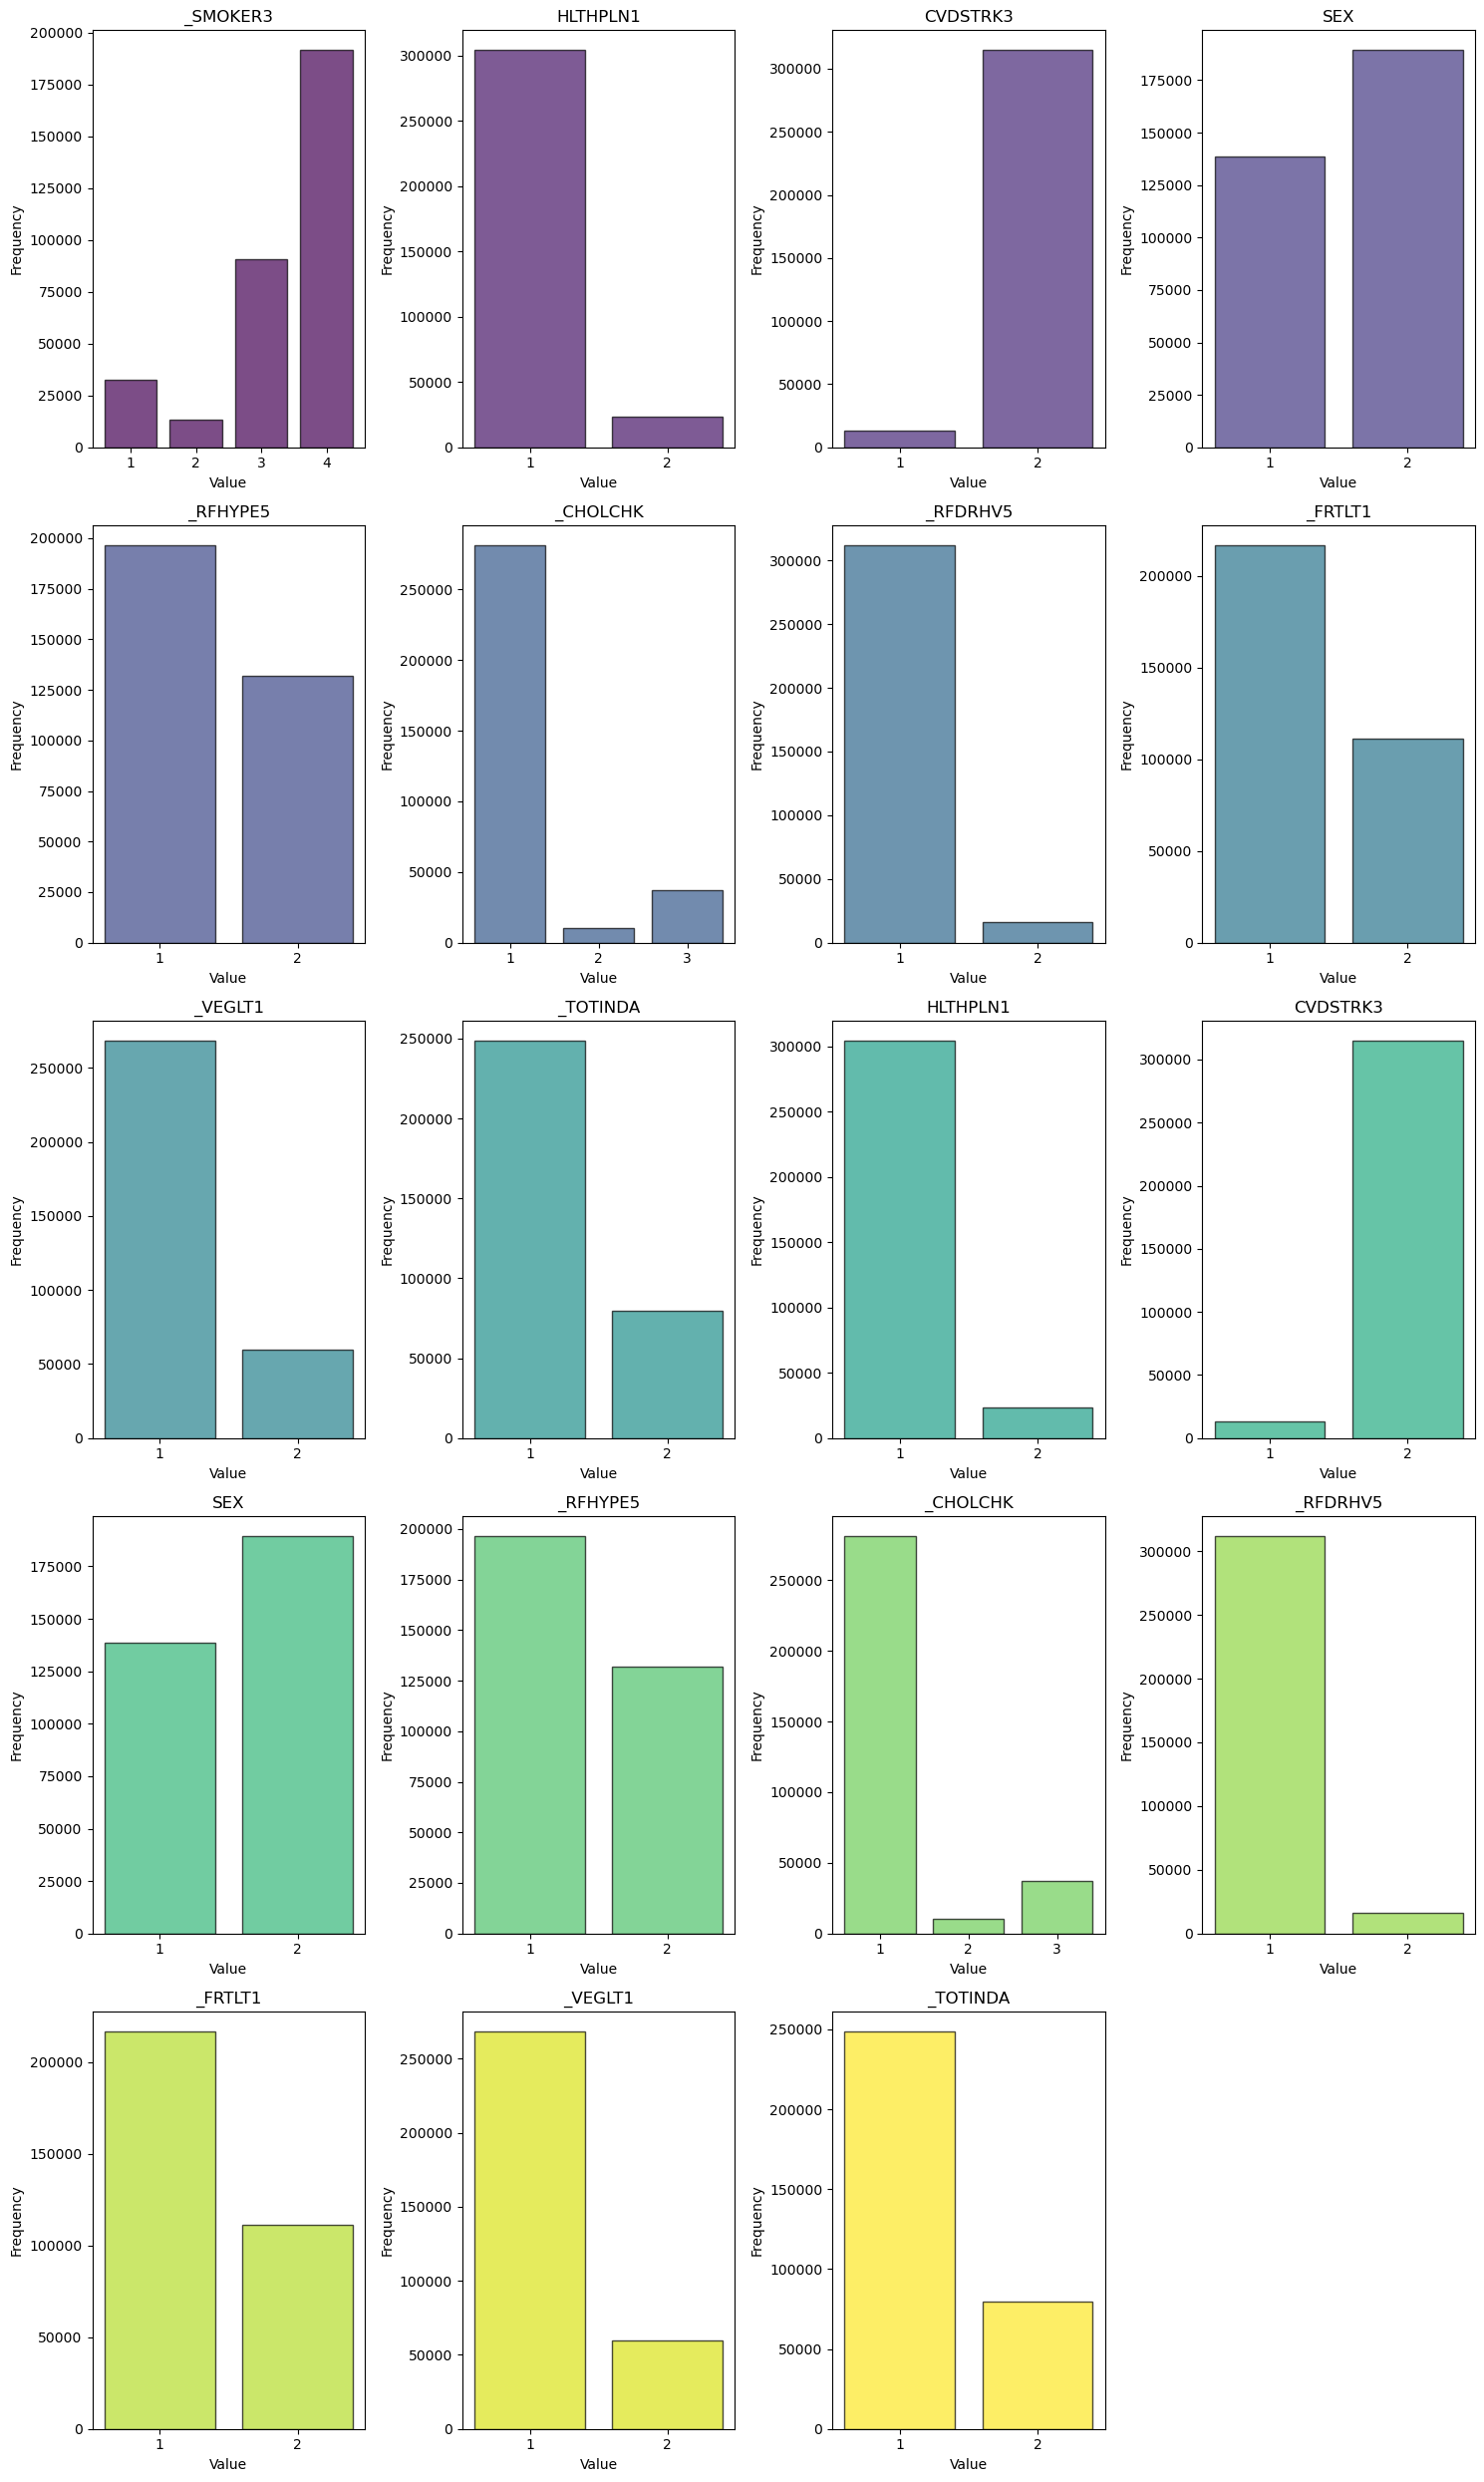

In [23]:
# Visualization of categorical features
data = x_train[:, categorical_features_idx]
data_list = [data[:, col] for col in range(len(categorical_features_idx))]
features_list = categorical_features
plot_histograms(data_list, features_list, num_cols=4)

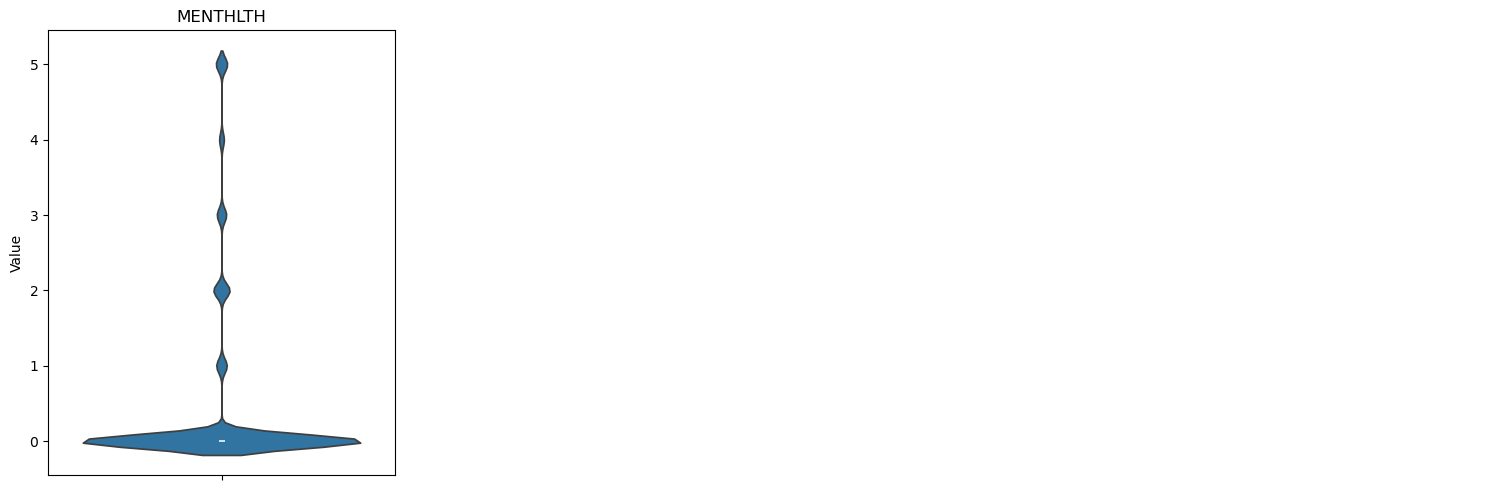

In [24]:
# Visualization of categorical features
data = x_train[:,continuous_features_idx]
data_list = [data[:, col] for col in range(len(continuous_features_idx))]
features_list = continuous_features
plot_boxplots(data_list, features_list, num_cols=4)

## Build model data
1. Add offset
2. Split train data into training and validation sets
3. Balance data 

In [26]:
# Add offset term
y_train, tx_train = build_model_data(y_train_processed, x_train_processed)
tx_test = np.c_[np.ones(x_test_processed.shape[0]), x_test_processed]

In [53]:
# Split data into train and validation sets
split_ratio = 0.7
split_index = int(len(tx_train) * split_ratio)

# Create a random permutation of indices
np.random.seed(20)
indices = np.random.permutation(len(tx_train))

# Split the indices for training and validation sets
train_indices = indices[:split_index]
validation_indices = indices[split_index:]

# Use the indices to split the data
tx_train_training = tx_train[train_indices]
tx_train_validation = tx_train[validation_indices]
y_train_training = y_train[train_indices]
y_train_validation = y_train[validation_indices]

In [55]:
# Balance data: oversample minority class
y_majority = y_train_training[y_train_training == 0]
y_minority = y_train_training[y_train_training == 1]
X_majority = tx_train_training[y_train_training.flatten() == 0,:]
X_minority = tx_train_training[y_train_training.flatten() == 1,:]

oversample_size = len(y_majority)
indices = np.random.choice(len(X_minority), oversample_size, replace=True)
X_minority_oversampled = X_minority[indices]
y_minority_oversampled = y_minority[indices]

tx_training_balanced = np.vstack((X_minority_oversampled, X_majority)) # Combine oversampled minority class with majority class
y_training_balanced = np.hstack((y_minority_oversampled, y_majority)).reshape((-1,1))

## Model selection and validation

The selected models are
- Gradient Descent with MSE loss function
- Stochastic Gradient Descent with MAE loss function
- Least squares 
- Regularized least squares
- Logistic regression
- Ridge logistic regression

they are evaluated on the metrics
- loss
- accuracy
- F1-score
- MSE
- R squared

and they are optimized over
- the learning rate - _iterative algorithms (GD, SGD)_
- the penalty - _regularized algorithms (ridge regression)_
- the training / validation split ratio 

##### Initialisation of the algorithm

In [59]:
# Define the parameters of the algorithms
max_iters = 100
learning_rate = np.linspace(0.01, 0.1, 10)
penalty = np.linspace(0.01, 10, 10)

# Initialization
w_initial = np.zeros((tx_training_balanced.shape[1],1))

#### Gradient Descent - MSE loss function

In [62]:
"""Gradient descent, mse loss function"""
# Iterate over learning rate parameter values 
gd_mse_loss_min = np.zeros(len(learning_rate))
gd_mse_accuracy = np.zeros(len(learning_rate))
gd_mse_f1_score = np.zeros(len(learning_rate))
gd_mse_rmse = np.zeros(len(learning_rate))
gd_mse_r_squared = np.zeros(len(learning_rate))
gd_mse_ws_var_gamma = []
gd_mse_losses_var_gamma = []

for idx, gamma in enumerate(learning_rate):
    
    # Execute optimization algorithm, save losses and weights at every iteration
    start_time = datetime.datetime.now()
    gd_mse_losses, gd_mse_ws = mean_squared_error_gd(y_training_balanced, tx_training_balanced, w_initial, max_iters, gamma)
    end_time = datetime.datetime.now()
    
    # Print excecution time
    execution_time = (end_time - start_time).total_seconds()
    print("GD - mse: gamma={g:.3f}, execution time={t:.3f} seconds \n".format(g=gamma, t=execution_time))

    # Compute accuracy metrics
    y_pred = tx_train_validation.dot(gd_mse_ws[-1])
    y_pred = np.where(y_pred > 0.5, 1, 0)

    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    accuracy = (tp + tn) /(tp + tn + fp + fn)
    f1_score = 2*tp/(2*tp + fp + fn)
    mse = calculate_mse(y_train_validation - y_pred)
    r2 = r_squared(y_train_validation, y_pred)
    
    # Save losses, weights, accuracy metrics for hyperparameter optimization over learning rate
    gd_mse_loss_min[idx] = gd_mse_losses[-1]
    gd_mse_accuracy[idx] = accuracy
    gd_mse_f1_score[idx] = f1_score
    gd_mse_rmse[idx] = np.sqrt(mse)
    gd_mse_r_squared[idx] = r2

    gd_mse_ws_var_gamma.append(gd_mse_ws[-1])
    gd_mse_losses_var_gamma.append(gd_mse_losses)
    

loss=0.11416432345385177
GD - mse: gamma=0.010, execution time=1.722 seconds 

loss=0.1092967985251964
GD - mse: gamma=0.020, execution time=1.863 seconds 

loss=0.10744099803102153
GD - mse: gamma=0.030, execution time=1.374 seconds 

loss=0.1064227609366397
GD - mse: gamma=0.040, execution time=1.278 seconds 

loss=0.10576780869532933
GD - mse: gamma=0.050, execution time=1.211 seconds 

loss=0.10533522149131379
GD - mse: gamma=0.060, execution time=1.114 seconds 

loss=0.10491063960796408
GD - mse: gamma=0.070, execution time=1.059 seconds 

loss=0.10462194551931946
GD - mse: gamma=0.080, execution time=0.914 seconds 

loss=0.10433319254306454
GD - mse: gamma=0.090, execution time=0.879 seconds 

loss=0.10411532160726665
GD - mse: gamma=0.100, execution time=0.997 seconds 



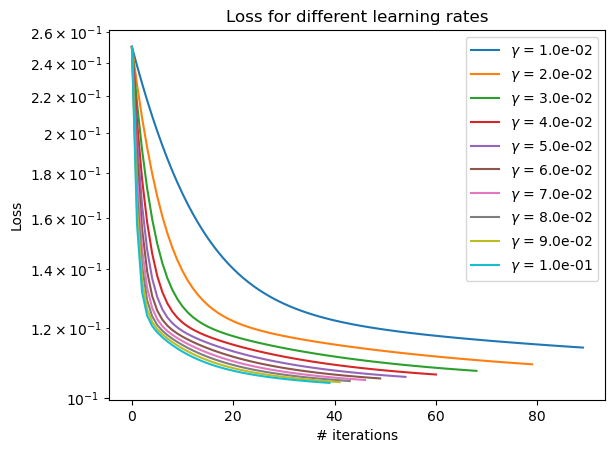

In [63]:
# Visualization
plot_loss_variable_gamma(gd_mse_losses_var_gamma, learning_rate)

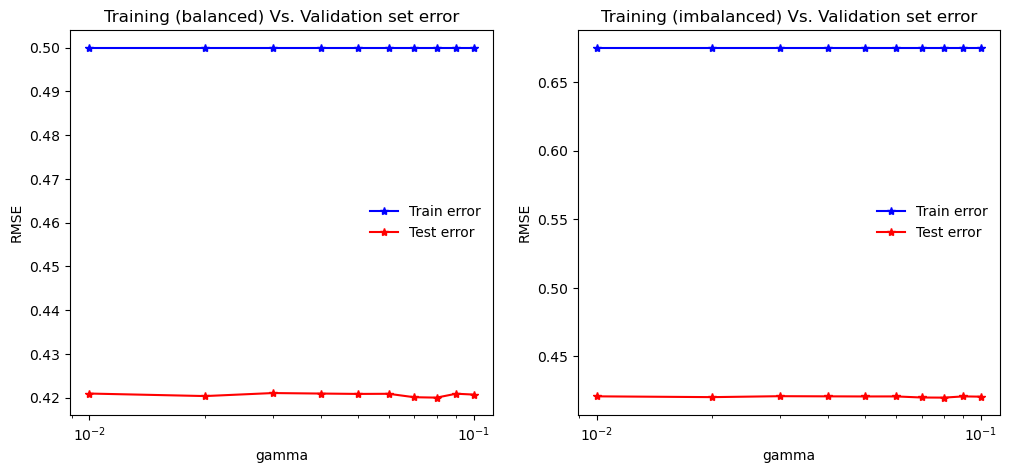

In [66]:
# Training (balanced) Vs. Validation error
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

rmse_validation = gd_mse_rmse
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, gd_mse_ws_var_gamma, learning_rate)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, learning_rate, 'gamma')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, learning_rate, 'gamma')

In [68]:
# Get optimal parameter and corresponding model weights, apply to test set
metrics = np.hstack([gd_mse_loss_min.reshape(-1,1), gd_mse_accuracy.reshape(-1,1), gd_mse_f1_score.reshape(-1,1), gd_mse_rmse.reshape(-1,1), gd_mse_r_squared.reshape(-1,1)])
metric_name = 'f1_score'

hyperparam_optimization(metric_name, metrics, gd_mse_ws_var_gamma, learning_rate, 'gamma', tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test, False)

The optimal parameter is gamma=0.100 given optimization of the metric f1_score evaluating 0.26673.
The optimal weights are w = [[ 0.17916531]
 [ 0.0169251 ]
 [ 0.116524  ]
 [-0.0028278 ]
 [-0.01066514]
 [ 0.01949307]
 [-0.01762788]
 [ 0.18155276]
 [-0.00992075]
 [-0.03877691]
 [-0.00892138]
 [ 0.01403729]
 [ 0.02197195]
 [ 0.0555981 ]
 [-0.01066514]
 [ 0.01949307]
 [-0.01762788]
 [ 0.18155276]
 [-0.00992075]
 [-0.03877691]
 [-0.00892138]
 [ 0.01403729]
 [ 0.02197195]
 [ 0.0555981 ]
 [-0.01124668]].
Other metrics evaluated for the model selection 
Loss = 0.104, Accuracy = 0.646, f1 score = 0.267, RMSE = 0.421, R squared = -3.430 

*******************************

True Vs. Predicted positive class (Heart Attack Rate) 

Train set balanced: True 0.500, Predicted 0.550.
Train set original: True 0.089, Predicted 0.396.
Validation set: True 0.088, Predicted 0.395.
Test set: Predicted 0.396.


#### Stochastic gradient descent - MSE loss function

In [ ]:
"""Stochastic gradient descent, mse loss function"""
# Iterate over learning rate parameter values 
learning_rate = np.linspace(0.001, 0.1, 10)

sgd_mse_loss_min = np.zeros(len(learning_rate))
sgd_mse_accuracy = np.zeros(len(learning_rate))
sgd_mse_f1_score = np.zeros(len(learning_rate))
sgd_mse_rmse = np.zeros(len(learning_rate))
sgd_mse_r_squared = np.zeros(len(learning_rate))
sgd_mse_ws_var_gamma = []
sgd_mse_losses_var_gamma = []

for idx, gamma in enumerate(learning_rate):
    
    # Execute optimization algorithm, save losses and weights at every iteration
    start_time = datetime.datetime.now()
    losses, ws = mean_squared_error_sgd(y_training_balanced, tx_training_balanced, w_initial, max_iters, gamma)
    end_time = datetime.datetime.now()
    
    # Print excecution time
    execution_time = (end_time - start_time).total_seconds()
    print("GD - mse: gamma={g:.3f}, execution time={t:.3f} seconds \n".format(g=gamma, t=execution_time))

    # Compute accuracy metrics
    y_pred = tx_train_validation.dot(ws[-1])
    y_pred = np.where(y_pred > 0.5, 1, 0)

    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    accuracy = (tp + tn) /(tp + tn + fp + fn)
    f1_score = 2*tp/(2*tp + fp + fn)
    mse = calculate_mse(y_train_validation - y_pred)
    r2 = r_squared(y_train_validation, y_pred)
    
    # Save losses, weights, accuracy metrics for hyperparameter optimization over learning rate
    sgd_mse_loss_min[idx] = losses[-1]
    sgd_mse_accuracy[idx] = accuracy
    sgd_mse_f1_score[idx] = f1_score
    sgd_mse_rmse[idx] = np.sqrt(mse)
    sgd_mse_r_squared[idx] = r2

    sgd_mse_ws_var_gamma.append(ws[-1])
    sgd_mse_losses_var_gamma.append(losses)
    

In [ ]:
# Visualization
plot_loss_variable_gamma(gd_mse_losses_var_gamma, learning_rate)

In [ ]:
# Training (balanced) Vs. Validation error
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

rmse_validation = sgd_mse_rmse
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, sgd_mse_ws_var_gamma, learning_rate)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, learning_rate, 'gamma')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, learning_rate, 'gamma')

In [ ]:
# Get optimal parameter and corresponding model weights, apply to test set
metrics = np.hstack([sgd_mse_loss_min.reshape(-1,1), sgd_mse_accuracy.reshape(-1,1), sgd_mse_f1_score.reshape(-1,1), sgd_mse_rmse.reshape(-1,1), sgd_mse_r_squared.reshape(-1,1)])
metric_name = 'loss'

hyperparam_optimization(metric_name, metrics, sgd_mse_ws_var_gamma, learning_rate, 'gamma', tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test, False)

#### Least squares

In [70]:
"""Least squares"""

# Execute optimization algorithm, save loss and w
start_time = datetime.datetime.now()
ls_loss, ls_w = least_squares(y_training_balanced, tx_training_balanced)
end_time = datetime.datetime.now()

# Print execution time 
execution_time = (end_time - start_time).total_seconds()
print("Least squares: execution time={t:.3f} seconds".format(t=execution_time))

# Compute accuracy metrics
y_pred = tx_train_validation.dot(ls_w)
y_pred = np.where(y_pred > 0.5, 1, 0)

tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
accuracy = (tp + tn) /(tp + tn + fp + fn)
f1_score = 2*tp/(2*tp + fp + fn)
mse = calculate_mse(y_train_validation - y_pred)
r2 = r_squared(y_train_validation, y_pred)

print_report(ls_w, False, tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test)

print('f1-score {}'.format(f1_score))

LinAlgError: Singular matrix

#### Ridge regression

In [ ]:
"""Ridge regression"""

# Iterate over penalty parameter values 
ridge_ls_loss = np.zeros(len(penalty))
ridge_ls_accuracy = np.zeros(len(penalty))
ridge_ls_f1_score = np.zeros(len(penalty))
ridge_ls_rmse = np.zeros(len(penalty))
ridge_ls_r_squared = np.zeros(len(penalty))
ridge_ls_ws_var_lambda = []

for idx, lambda_ in enumerate(penalty):

    # Execute optimization algorithm, save w 
    start_time = datetime.datetime.now()
    ridge_ls_losses, ridge_ls_ws = ridge_regression(y_training_balanced, tx_training_balanced, lambda_)
    end_time = datetime.datetime.now()

    # Print execution time 
    execution_time = (end_time - start_time).total_seconds()
    print("Ridge regression: lambda={l:.3f}, execution time={t:.3f} seconds \n".format(l=lambda_, t=execution_time))

    # Compute accuracy metrics
    y_pred = tx_train_validation.dot(ridge_ls_ws)
    y_pred = np.where(y_pred > 0.5, 1, 0)

    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    accuracy = (tp + tn) /(tp + tn + fp + fn)
    f1_score = 2*tp/(2*tp + fp + fn)
    mse = calculate_mse(y_train_validation - y_pred)
    r2 = r_squared(y_train_validation, y_pred)
    
    # Save losses, weights, accuracy metrics for hyperparameter optimization over learning rate
    ridge_ls_loss[idx] = ridge_ls_losses
    ridge_ls_accuracy[idx] = accuracy
    ridge_ls_f1_score[idx] = f1_score
    ridge_ls_rmse[idx] = np.sqrt(mse)
    ridge_ls_r_squared[idx] = r2

    ridge_ls_ws_var_lambda.append(ridge_ls_ws)
    

In [ ]:
fig = plt.figure()
plt.plot(penalty, ridge_ls_loss)
plt.title("Loss as a function of the penalty")
plt.xlabel("lambda")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Training (balanced) Vs. Validation error
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

rmse_validation = ridge_ls_rmse
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, ridge_ls_ws_var_lambda, penalty)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, penalty, 'lambda')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, penalty, 'lambda')

In [ ]:
metrics = np.hstack([ridge_ls_loss.reshape(-1,1), ridge_ls_accuracy.reshape(-1,1), ridge_ls_f1_score.reshape(-1,1), ridge_ls_rmse.reshape(-1,1), ridge_ls_r_squared.reshape(-1,1)])
metric_name = 'loss'

hyperparam_optimization(metric_name, metrics, ridge_ls_ws_var_lambda, penalty, 'lambda', tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test, False)

#### Logistic regression

In [ ]:
"""Logistic regression - gradient descent"""
# Iterate over learning rate parameter values 
logistic_gd_loss_min = np.zeros(len(learning_rate))
logistic_gd_accuracy = np.zeros(len(learning_rate))
logistic_gd_f1_score = np.zeros(len(learning_rate))
logistic_gd_rmse = np.zeros(len(learning_rate))
logistic_gd_r_squared = np.zeros(len(learning_rate))
logistic_gd_ws_var_gamma = []
logistic_gd_losses_var_gamma = []

for idx, gamma in enumerate(learning_rate):
    
    # Execute optimization algorithm, save losses and w at every iteration
    start_time = datetime.datetime.now()
    logistic_gd_losses, logistic_gd_ws = logistic_regression(y_training_balanced, tx_training_balanced, w_initial, max_iters, gamma)
    end_time = datetime.datetime.now()
    
    # Print excecution time
    execution_time = (end_time - start_time).total_seconds()
    print("Logistic regression - Gradient descent: gamma={g:.3f}, execution time={t:.3f} seconds \n".format(g=gamma, t=execution_time))

    # Compute accuracy metrics
    y_pred = sigmoid(tx_train_validation.dot(logistic_gd_ws[-1])) 
    y_pred = np.where(y_pred > 0, 1, 0)

    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    accuracy = (tp + tn) /(tp + tn + fp + fn)
    f1_score = 2*tp/(2*tp + fp + fn)
    mse = calculate_mse(y_train_validation - y_pred)
    r2 = r_squared(y_train_validation, y_pred)
    
    # Save losses, weights, accuracy metrics for hyperparameter optimization over learning rate
    logistic_gd_loss_min[idx] = logistic_gd_losses[-1]
    logistic_gd_accuracy[idx] = accuracy
    logistic_gd_f1_score[idx] = f1_score
    logistic_gd_rmse[idx] = np.sqrt(mse)
    logistic_gd_r_squared[idx] = r2

    logistic_gd_ws_var_gamma.append(logistic_gd_ws[-1])
    logistic_gd_losses_var_gamma.append(logistic_gd_losses)

In [ ]:
# Visualization
plot_loss_variable_gamma(logistic_gd_losses_var_gamma, learning_rate)

In [ ]:
# Training (balanced) Vs. Validation error
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

rmse_validation = logistic_gd_rmse
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, logistic_gd_ws_var_gamma, learning_rate)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, learning_rate, 'gamma')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, learning_rate, 'gamma')

In [ ]:
# Get optimal parameter and corresponding model weights, apply to test set
metrics = np.hstack([logistic_gd_loss_min.reshape(-1,1), logistic_gd_accuracy.reshape(-1,1), logistic_gd_f1_score.reshape(-1,1), logistic_gd_rmse.reshape(-1,1), logistic_gd_r_squared.reshape(-1,1)])
metric_name = 'loss'

hyperparam_optimization(metric_name, metrics, logistic_gd_ws_var_gamma, learning_rate, 'gamma', tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test, True)

#### Regularized Logistic Regression 

In [ ]:
def reg_logistic_regression(y, tx, w_initial, max_iters, gamma, lambda_):
    """Regularized logistic regression method.
        
    Args : 
        x = input matrix of the training set (N,D) where N is the number of samples and D the number of features
        y = output vector of the training set(N,) where N is the number of samples
        initial_w: numpy array of shape=(D, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (D, ), for each iteration of GD
    """

    # Define parameters to store w and loss
    ws = [w_initial]
    losses = []
    
    w = w_initial
    for n_iter in range(max_iters):
        # compute loss, gradient
        pred = sigmoid(tx.dot(w))
        grad = tx.T.dot(pred - y) * (1 / y.shape[0]) + 2 * lambda_ * w     
        loss = y.T.dot(np.log(pred)) + (1 - y).T.dot(np.log(1 - pred))
        loss = np.squeeze(-loss).item() * (1 / y.shape[0]) + lambda_ * np.squeeze(w.T.dot(w))
        # update w by gradient descent
        w = w - gamma * grad

        # store w and loss
        ws.append(w)
        losses.append(loss)

        # convergence criterion
        # if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
        #    break

    print("loss={l}".format(l=losses[-1]))
    return losses, ws

In [ ]:
"""Regularized logistic regression"""

# Iterate over penalty parameter values 
reg_lr_loss = np.zeros((len(penalty), len(learning_rate)))
reg_lr_accuracy = np.zeros((len(penalty), len(learning_rate)))
reg_lr_f1_score = np.zeros((len(penalty), len(learning_rate)))
reg_lr_rmse = np.zeros((len(penalty), len(learning_rate)))
reg_lr_r_squared = np.zeros((len(penalty), len(learning_rate)))
reg_lr_ws_var_lambda_and_gamma = []
reg_lr_losses_var_lambda_and_gamma = []

for idx_l, lambda_ in enumerate(penalty):

    for idx_g, gamma in enumerate(learning_rate):
    
        # Execute optimization algorithm, save losses and w at every iteration
        start_time = datetime.datetime.now()
        reg_logistic_losses, reg_logistic_ws = reg_logistic_regression(y_training_balanced, tx_training_balanced, w_initial, max_iters, gamma, lambda_)
        end_time = datetime.datetime.now()
        
        # Print excecution time
        execution_time = (end_time - start_time).total_seconds()
        print("Regularized logistic regression: gamma={g:.3f}, lambda={l:.3f}, execution time={t:.3f} seconds \n".format(g=gamma, l= lambda_, t=execution_time))
    
        # Compute accuracy metrics
        y_pred = tx_train_validation.dot(reg_logistic_losses[-1])
        y_pred = np.where(y_pred > 0, 1, 0)
    
        tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
        accuracy = (tp + tn) /(tp + tn + fp + fn)
        f1_score = 2*tp/(2*tp + fp + fn)
        mse = calculate_mse(y_train_validation - y_pred)
        r2 = r_squared(y_train_validation, y_pred)
        
        # Save losses, weights, accuracy metrics for hyperparameter optimization over learning rate
        reg_lr_loss[idx_l, idx_g] = reg_logistic_losses[-1]
        reg_lr_accuracy[idx_l, idx_g] = accuracy
        reg_lr_f1_score[idx_l, idx_g] = f1_score
        reg_lr_rmse[idx_l, idx_g] = np.sqrt(mse)
        reg_lr_r_squared[idx_l, idx_g] = r2
    
        reg_lr_ws_var_lambda_and_gamma.append(reg_logistic_ws[-1].flatten())
        reg_lr_losses_var_lambda_and_gamma.append(reg_logistic_losses)

In [ ]:
reg_lr_ws_var_lambda_and_gamma = np.reshape(reg_lr_ws_var_lambda_and_gamma, (len(penalty), len(learning_rate), len(w_initial)))
reg_lr_losses_var_lambda_and_gamma = np.reshape(reg_lr_losses_var_lambda_and_gamma, (len(penalty), len(learning_rate), max_iters))

In [ ]:
# Get optimal parameter and corresponding model weights, apply to test set
metric_name = 'loss'
if metric_name == 'loss':
    opt = 'min'
    metric = reg_lr_loss
elif metric_name == 'accuracy':
    opt = 'max'
    metric = reg_lr_accuracy
elif metric_name == 'f1_score':
    opt = 'max'
    metric = reg_lr_f1_score
elif metric_name == 'RMSE':
    opt = 'min'
    metric = reg_lr_rmse
elif metric_name == 'R_squared':
    opt = 'max'
    metric = reg_lr_r

if opt == 'min':
    opt_index = np.argmin(metric)
else:
    opt_index = np.argmax(metric)

# Convert this index to row and column indices
opt_row, opt_col = np.unravel_index(opt_index, metric.shape)

opt_lambda = penalty[opt_row]
opt_gamma = learning_rate[opt_col]
opt_w = reg_lr_ws_var_lambda_and_gamma[opt_row, opt_col]
opt_metric = metric[opt_row, opt_col]

print('The optimal parameters are lambda ={l:.3f} and gamma = {g:.3f} given optimization of the metric {metr} evaluating {m:.5f}.'.format(l = opt_lambda, g=opt_gamma, metr=metric_name, m=opt_metric))
print('The optimal weights are w = {}.'.format(opt_w))
print('Other metrics evaluated for the model selection \nLoss = {l:.3f}, Accuracy = {a:.3f}, f1 score = {f:.3f}, RMSE = {r:.3f}, R squared = {rs:.3f} \n'.format(l=reg_lr_loss[opt_row, opt_col], a=reg_lr_accuracy[opt_row, opt_col], f=reg_lr_f1_score[opt_row, opt_col], r=reg_lr_rmse[opt_row, opt_col], rs=reg_lr_r_squared[opt_row, opt_col]))
print('*******************************\n')

print_report(opt_w, True, tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test)

In [ ]:
# Training (balanced) Vs. Validation error
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

reg_lr_ws_var_lambda = [reg_lr_ws_var_lambda_and_gamma[row, opt_col].reshape(-1,1) for row in np.arange(np.shape(reg_lr_ws_var_lambda_and_gamma)[0])]
rmse_validation = reg_lr_rmse[:,opt_col]
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, reg_lr_ws_var_lambda, penalty)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, penalty, 'lambda')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, penalty, 'lambda')

In [ ]:
# Training (balanced) Vs. Validation error
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

reg_lr_ws_var_gamma = [reg_lr_ws_var_lambda_and_gamma[opt_row, col].reshape(-1,1) for col in np.arange(np.shape(reg_lr_ws_var_lambda_and_gamma)[1])]
rmse_validation = reg_lr_rmse[opt_row, :]
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, reg_lr_ws_var_gamma, learning_rate)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, penalty, 'gamma')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, penalty, 'gamma')